<a href="https://colab.research.google.com/github/MaiNga-uit/CS2225.CH1507/blob/master/source_code/%5BCS2225%5DTesting_6_fruits_detection_model_with_multiple_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Download model đã được nhóm train sẵn và upload lên goodle drive:


In [ ]:
import gdown

modelUrl = 'https://drive.google.com/uc?id=17F6ARN39yEebwc9l3_04JeaCrsyUV-zk' #URL cố định dùng để download.
output = '/content/trained_model.zip' 
gdown.download(modelUrl, output, quiet=False)

!unzip -o '/content/trained_model.zip' -d '/content/'
!rm -r '/content/trained_model.zip'

#2. Cài đặt Object detection API:

In [2]:
import os
import pathlib

# Clone the tensorflow models repository về máy
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models


Cloning into 'models'...
remote: Enumerating objects: 2399, done.
remote: Counting objects: 100% (2399/2399), done.
remote: Compressing objects: 100% (1997/1997), done.
remote: Total 2399 (delta 573), reused 1395 (delta 375), pack-reused 0
Receiving objects: 100% (2399/2399), 30.77 MiB | 30.65 MiB/s, done.
Resolving deltas: 100% (573/573), done.


In [ ]:
#Install object detection api
# Có thể có 1 số error do lỗi không tương thích, vẫn có thể đi tiếp được
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

#3. Import thư viện và config cần thiết trước khi run test:



In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline


In [7]:
#Hàm load image
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
pipeline_file = '/content/CS2225/output_model/pipeline.config'
#recover our saved model
pipeline_config = pipeline_file

#Model checkpoint
model_dir = '/content/CS2225/output_model/checkpoint/ckpt-0'
configs = config_util.get_configs_from_pipeline_file(pipeline_file)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join('/content/CS2225/output_model/checkpoint/ckpt-0'))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [9]:
#Load label map
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap('/content/CS2225/fruit_label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

#4. Cách test 1: test bằng cách input 01 hình ảnh:
* **Note**: 
   * có 3 cách test: 
    *   input 1 hình ảnh, output hiển thị trực tiếp ngay phía dưới đoạn code
    *   chụp hình từ webcam (xem mục số 5)
    *   input 1 folder có chứa ảnh, kết quả sẽ được ghi vào folder /content/test_result (xem mục số 6)

   * Lần đầu run thì output sẽ chậm


* Trong folder **'CS2225/test_images/'** **(folder này đã được download ở mục 2)** nhóm đã chuẩn bị sẵn 1 số hình ngẫu nhiên để thuận tiện việc test.


Downloading...
From: https://vcdn-kinhdoanh.vnecdn.net/2018/12/12/thanh-long-7228-1544589820.jpg
To: /content/test_img.jpg
100%|██████████| 36.1k/36.1k [00:00<00:00, 1.90MB/s]


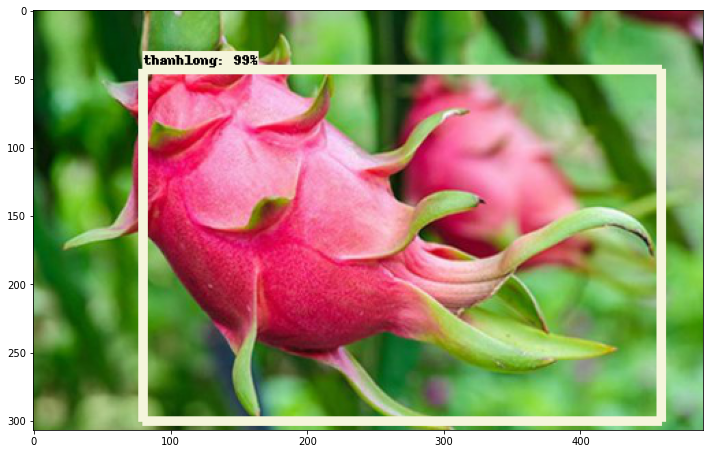

In [11]:
import random
import glob
import cv2

# Cách 1.a: Cung cấp 1 url để download hình ảnh từ internet về:
imgUrl = 'https://vcdn-kinhdoanh.vnecdn.net/2018/12/12/thanh-long-7228-1544589820.jpg'
gdown.download(imgUrl, '/content/test_img.jpg', quiet=False)
img = '/content/test_img.jpg'

# Cách 1.b: Randomly chọn hình ảnh trong folder CS2225/test_images - nhóm đã chuẩn bị sẵn 1 số hình để tiện việc test.
# TEST_IMAGE_PATHS = glob.glob('/content/CS2225/test_images/*.jpg')
# img = random.choice(TEST_IMAGE_PATHS)


image_np = load_image_into_numpy_array(img)
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.6,
      agnostic_mode=False,
      line_thickness=7
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

#5. Cách test 2: Lấy hình được chụp từ webcam
* Webcam sẽ được bật, click 1 click để chụp hình từ webcam
* Output: hình ảnh được chụp cùng với bounding box, label name, score

In [12]:
# Define hàm take_photo: làm nhiệm vụ bật webcam & chụp hình
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<div class="video_container">
  <video autoplay
   width=%d height=%d></video>
  <div style='position: absolute;top: 40px; left: 40px; font-size: 40px; color: green;'>Click to save!</div>
</div>
<script>
var video = document.querySelector('video')
navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
OUTPUT_IMG_FROM_WEBCAM_PATH = '/content/test_img.jpg'
def take_photo(filename=OUTPUT_IMG_FROM_WEBCAM_PATH, quality=0.8, size=(800,600)):
  handle = display(HTML(VIDEO_HTML % (size[0],size[1],quality)), display_id='videoHTML')
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  if filename:
    f = io.BytesIO(binary)
    Image.open(f).save(filename)
  else:
    f = io.BytesIO(binary)
    return np.asarray(Image.open(f))

In [ ]:
import random
import glob
import cv2

take_photo()
img = OUTPUT_IMG_FROM_WEBCAM_PATH
image_np = load_image_into_numpy_array(img)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.6,
      agnostic_mode=False,
      line_thickness=12
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

#6. Cách test 3: Chạy thử nghiệm trên toàn bộ tập ảnh test và lưu vào drive
* Input: Folder chứa bộ ảnh cần test (kiểu *.jpg)
* Output: Kết quả detect sẽ được ghi vào folder được chỉ định trong Drive

**Lưu ý:** Thời gian thực hiện tùy thuộc số lượng và độ phân giải của ảnh cần test



**Khai báo một số phương thức hỗ trợ**

In [ ]:
def writeToFile(dir, name):
  out_dir = dir
  img_name = name

  json_string = json.dumps(selected_dict)
  output_img_name = img_name
  out_json = out_dir + output_img_name + ".json"
  myfile = open(out_json, "w")
  print(json_string, file=myfile)
  myfile.close()

  out_img = out_dir + img_name + ".jpg"

  im_rgb = cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB)
  cv2.imwrite(out_img, im_rgb)

In [ ]:
import cv2
import os

def load_filename_from_folder(folder):
    names = []
    for basename in os.listdir(folder):
      names.append( os.path.splitext(basename)[0])
    return names

In [ ]:

# create folder to save output
# just execute once
# this is used to create new directory for testing base on current date time
import os.path
from os import path
from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")

main_test_result_dir = "/content/test_result"
if path.exists(main_test_result_dir) == False:
  os.mkdir(main_test_result_dir)

auto_directoryname = "v_" + dt_string;
test_result_dir = main_test_result_dir + "/" + auto_directoryname
drive_auto_dir = auto_directoryname
os.mkdir(test_result_dir)

In [ ]:
import random
import glob
import cv2
import json
from resizeimage import resizeimage
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.builders import model_builder

images = load_filename_from_folder("/content/CS2225/test_images/")

for img_name in images:
  #img_name = 'val_thanhlong_5'
  img = '/content/CS2225/test_images/' + img_name + '.jpg'

  # with open(img, 'r+b') as f:
  #     with Image.open(f) as image:
  #         cover = resizeimage.resize_cover(image, [300, 300])
  #         cover.save('/content/resized_test_img.jpg', image.format)

  # resized_img = '/content/resized_test_img.jpg'

  image_np = load_image_into_numpy_array(img)
  input_tensor = tf.convert_to_tensor(
      np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, predictions_dict, shapes = detect_fn(input_tensor)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.6,
        agnostic_mode=False,
        line_thickness=7
  )

  plt.figure(figsize=(12,16))
  # plt.imshow(image_np_with_detections)
  # print((detections['detection_classes'][0].numpy() + label_id_offset).astype(int))
  # plt.show()

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(detections.pop('num_detections'))
  # num_detections = int(detections.pop('num_detections'))
  detection_index = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)

  detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections

  # detection_classes should be ints.
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  height, width, color = image_np.shape

  selected_dict= dict()
  selected_dict['objects'] = []
  score_threshold = 0.5
  for i in range(num_detections):
      if detections['detection_scores'][i] > score_threshold:
          bbox_list = list(detections['detection_boxes'][i])
          bbox_list[0]=int(round(bbox_list[0]*height))
          bbox_list[1]=int(round(bbox_list[1]*width))
          bbox_list[2]=int(round(bbox_list[2]*height))
          bbox_list[3]=int(round(bbox_list[3]*width))
          selected_dict['objects'].append({
              'label' : category_index[detection_index[i]]['name'],
              'bbox' : bbox_list,
              'score' : float(detections['detection_scores'][i])
              })

  # print(selected_dict)


  writeToFile(test_result_dir, img_name)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive

import shutil

source = test_result_dir
destination = "/content/drive/MyDrive/CS2225/test_result/" + drive_auto_dir
shutil.copytree(source, destination)